# Make Obs Movie Plots
## updating prior version DyeObsMovie.py into notebook format
And revising with better projection method.

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 11 15:24:57 2019

@author: jacob
"""

import h5py
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
from scipy.interpolate import griddata
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy.ma as ma

#from matplotlib.mlab import griddata
import datetime as dt
import gsw
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
#%%
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

In [5]:
#%% LOAD MET DATA

filename = '/data/pacific/jacob/LATMIXDYE/LATMIX/LES_COARE35_forcing.mat' # Front run
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)

# List all groups
yearday = matfile['yearday']
tau_cs = matfile['tau_cs']
tau_d = matfile['tau_d']
qnet = matfile['net_heat_flux']
tmag = np.sqrt(tau_cs**2 + tau_d**2)

#%% LOAD SST MAP

filename = '/data/pacific/jacob/LATMIXDYE/SatData/AVHRR493data.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)

sstdatafile=matfile['sstdata']

temp0 = sstdatafile[0]
temp1 = sstdatafile[1]
temp2 = sstdatafile[2]

sstdata = temp0.sst
sst=(sstdata.bytes-0.5)*sstdata.scale; 
sst[sst<0] = np.nan; 
sst=sst+sstdata.min

latgrid = temp0.subset.latgrid
longrid = temp0.subset.lonEgrid

latlimr = np.argmin(np.abs(latgrid-38))
latliml = np.argmin(np.abs(latgrid-40))
lonliml = np.argmin(np.abs(longrid+66))
lonlimr = np.argmin(np.abs(longrid+62))

#%% LOAD DYE DATA
#filename = '/home/jacob/dedalus/LATMIX/LatMix_2012/inj_data_2012'
#matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
#matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)

filename = '/data/pacific/jacob/LATMIXDYE/LatMix_2012_Transfer/my_triaxus_SI2'
matfile = spio.loadmat(filename,struct_as_record=True, squeeze_me=True)

latK = matfile['lat_ts']
lonK = matfile['lon_ts']

depth = matfile['DEPTH']
fluorppb = matfile['FLUORPPB']
shiplog = matfile['SHIPLOG']
rho = matfile['PDENS']
jday = matfile['JDAY']
lat = matfile['LAT']
lon = matfile['LON']
II = matfile['II'] # This indexes individual gulf stream crossings

fluorppb[np.isnan(fluorppb)] = 0
fluorppb[fluorppb<0] = 0
fluorppb[fluorppb==0] = 1e-10
nd, ns = shiplog.shape

#%% LOAD TIMESERIES DATA

jday_ts = matfile['jday_ts']
fluorppb_ts = matfile['fluorPPB_ts']
depth_ts = matfile['depth_ts']
lat_ts = matfile['lat_ts']
lon_ts = matfile['lon_ts']
rho_ts = matfile['pdens_ts']
T_ts = matfile['T_ts']
S_ts = matfile['S_ts']
ii = matfile['ii']
    #%% LOAD FLOAT DATA
filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Mar05_SI_2_Track.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
floatstruct = matfile['F']
flat = floatstruct.lat
flon = floatstruct.lon
fyd = floatstruct.yd-1 #Craig convention

fyds = floatstruct.yds - 1
flats = floatstruct.lats
flons = floatstruct.lons

#sf = 10
#poly = np.polyfit(fyd,flat,6)
#flat_s = np.poly1d(poly)(fyd)
#
#window_size, poly_order = 51, 3
#flat_s = savgol_filter(flat, window_size, poly_order, deriv=0)
#flon_s = savgol_filter(flon, window_size, poly_order, deriv=0)
fvellat = np.gradient(flats)/np.gradient(fyds*86400)
fvellon = np.gradient(flons)/ np.gradient(fyds*86400)
fdir = np.arctan2(fvellat, fvellon)

filename = '/data/pacific/jacob/LATMIXDYE/FloatData_Transfer/Env.mat'
matfile = spio.loadmat(filename,struct_as_record=False, squeeze_me=True)
fT = matfile['T']
fS = matfile['S']
fT = np.mean(fT, axis=-1)# Top and bottom sensors
fS = np.mean(fS, axis=-1)
fydr = matfile['yd'] - 1
fP = matfile['P']

In [348]:
import pyproj as proj

def projectCoords(lat, lon, flat, flon, projection='epsg:26920'):
    if projection == 'naive':
        y = (lat)*111e3 
        x = (lon*np.cos(lat*np.pi/180))*111e3
        #x -=x[0]; y -= y[0]
        fy = flat*111e3
        fx = flon*111e3*np.cos(flat*np.pi/180)
    else:
        transformer = proj.Transformer.from_crs('epsg:4326', projection, always_xy=True)
        x, y = transformer.transform(lon, lat)
        #x -= x[0]; y -= y[0]
        fx, fy = transformer.transform(flon, flat)

    fxv = np.gradient(fx)/np.gradient(fyds*86400)
    fyv = np.gradient(fy)/np.gradient(fyds*86400)
    fxvm = (np.interp(np.nanmean(jday[:,span]), fyds, fxv))
    fyvm = (np.interp(np.nanmean(jday[:,span]), fyds, fyv))
    fang = np.arctan2(fyvm, fxvm)
    theta = -fang
    #print(theta)
    meanfloaty = np.interp(np.nanmean(jday[:,span]), fyds, fy) # What is the float lat during the survey average?
    meanfloatx = np.interp(np.nanmean(jday[:,span]), fyds, fx) # What is the float lon during the survey average?
    #print(meanfloatx)
    x = x - meanfloatx; y = y - meanfloaty
    print(np.sum(np.isfinite(x)))
    rotatedpoints = (x*np.cos(theta)-y*np.sin(theta), x*np.sin(theta)+y*np.cos(theta))

    return rotatedpoints[0]/1000, rotatedpoints[1]/1000

In [349]:
#Define Projection Function
def getProjectedSection(crossing):
    span = range(II[crossing,0], II[crossing,1])
    span_ts = range(ii[crossing,0], ii[crossing,1])

    values = fluorppb[:,span]
    values[values<=0] = 1e-10
    values = values/np.nanmax(fluorppb)
    # Project to float normal coordinate system

    # First calc the survey mean float angle
#    tmean = np.nanmean(jday[:,span])
#    fvellatm = np.mean(np.interp(tmean, fyds, fvellat)) # mean float latitude velocity during survey
#    fvellonm = np.mean(np.interp(tmean, fyds, fvellon)) # mean float longitude velocity during survey
#    fang = np.arctan2(fvellatm, fvellonm) # angle of float velocity (cart) XXX - are these accurate calcs?
    # Then calculate survey angle relative to float 
#    theta = -fang # 0 if pure zonal
    #theta = 0
#    y = lat[:,span]*111e3 
#    x = lon[:,span]*111e3*np.cos(lat[:,span]*np.pi/180)
    
    # Now calculate closest point of appraoch
#    meanfloaty = np.interp(np.nanmean(jday[:,span]), fyds, flats)*111e3 # What is the float lat during the survey average?
#    meanfloatx = np.interp(np.nanmean(jday[:,span]), fyds, flons*np.cos(flats*np.pi/180))*111e3 # What is the float lon during the survey average?
    #floatindx = np.nanargmin((x.ravel() - meanfloatx)**2 )
    #x = x - x.ravel()[floatindx]
    #floatindy = np.nanargmin((y.ravel() - meanfloaty)**2)
    #y = y - y.ravel()[floatindy]
    #print(floatind)
#    x = x - meanfloatx
#    y = y - meanfloaty
    
    #x = x-np.nanmin(x); y = y - np.nanmin(y)
#    rotatedpoints = (x*np.cos(theta)-y*np.sin(theta), x*np.sin(theta)+y*np.cos(theta))
#    shiplogc = rotatedpoints[1]/1000 
    rx, shiplogc = projectCoords(lat[:,span], lon[:,span], floatstruct.lats, floatstruct.lons)
    print(shiplogc.shape)
    #shiplogc = shiplogc - shiplogc[floatind]
    # Interpolate the data
    grid_x = np.linspace(-6, 6, 12*4)
    grid_y = depth[:,1]
    GX, GY = np.meshgrid(grid_x, grid_y)

    # ALTERNATELY INTERPOLATE 1D AT EACH DEPTH BIN
    deps = depth_ts[span]
    grc = np.zeros((grid_y.size, grid_x.size))
    R = np.zeros((grid_y.size, grid_x.size))
    sl = shiplogc
    #print(sl[100,:])
    for i in range(0, grid_y.size):
        vtemp = values[i,:]
        rtemp = rho[i,span]
        stemp = sl[i,:]
        m = (np.isfinite(vtemp)) #& ~(np.insert(np.diff(stemp), 0, 0) <0)
        stemp = stemp[m]
        vtemp = vtemp[m]
        rtemp = rtemp[m]
        grc[i, :] = interp.interp1d(stemp, vtemp, kind='nearest',bounds_error=False, assume_sorted=False)(grid_x)
        R[i, :] = interp.interp1d(stemp, rtemp, kind='linear',bounds_error=False)(grid_x)

    points = (shiplogc.ravel(), depth[:,span].ravel() )
    rhov = rho[:,span].ravel()
    mask = np.isfinite(shiplogc.ravel() + depth[:,span].ravel()+rho[:,span].ravel())
    #R = griddata((shiplogc.ravel()[mask], depth[:,span].ravel()[mask]), rhov[mask], (GX, GY), method='linear', rescale=True)

    # Create mask of upper most depths (we don't want to extrapolate above tow-yo depths)
    depthnorm = depth[:,span]
    sli = np.zeros((len(span),))
    depthi = np.zeros((len(span)))
    for i in range(0,len(span)):
        depthi[i] = depth[np.where(np.isfinite(shiplog[:,span[i]]))[0][0],span[i]]
        sli[i] = shiplogc[np.where(np.isfinite(shiplog[:,span[i]]))[0][0],i]
    mindsi = interp.interp1d(sli, depthi, kind='linear', bounds_error=False, fill_value='extrapolate')(grid_x)
    mindgrid = np.tile(mindsi, (grid_y.size, 1))
    grc[GY<mindgrid] = np.nan
    R[GY<mindgrid] = np.nan
    # Mask the bottom of the domain
    sli = np.zeros((len(span),))
    depthi = np.zeros((len(span)))
    for i in range(0,len(span)):
        depthi[i] = depth[np.where(np.isfinite(shiplog[:,span[i]]))[0][-1],span[i]]
        sli[i] = shiplogc[np.where(np.isfinite(shiplog[:,span[i]]))[0][-1],i]
    mindsi = interp.interp1d(sli, depthi, kind='linear', bounds_error=False, fill_value='extrapolate')(grid_x)
    mindgrid = np.tile(mindsi, (grid_y.size, 1))
    grc[GY>mindgrid] = np.nan

    #Mask values outside the survey distance (y) direction
    grc[GX>np.nanmax(shiplogc)] = np.nan
    maxx = np.zeros((len(GX),))
    minx = np.zeros((len(GX),))
    for i in range(0,len(GX)):
        stemp = np.sort(shiplogc[i,:])
        #print(stemp)
        inds = np.where(np.isfinite(stemp))[0]
        if inds.size>0:
            maxx[i] = stemp[inds[-1]]
            minx[i] = stemp[inds[0]]
    maxxi = np.tile(maxx, (grid_x.shape[-1], 1)).T
    minxi = np.tile(minx, (grid_x.shape[-1], 1)).T
    grc[GX>maxxi] = np.nan
    grc[GX<minxi] = np.nan
    R[GX>maxxi] = np.nan
    R[GX<minxi] = np.nan
    
    #m = GX[0:300,:] >= np.nanmax(shiplogc[0:200,:])
    #gctemp = grc[0:300,:]
    #gctemp[m] = np.nan
    #grc[0:300,:] = gctemp
#for i in range(0,depth.shape[0]):
#    maxx = np.nanmax(shiplogc[i,:])
#    m = GX[i,:]>maxx
#    grc[i,m] = np.nan
#R[GX>np.max(points[0])] = np.nan
    shiplogobs = shiplogc.ravel()
    depthobs = depth[:,span].ravel()
    m = np.isfinite(shiplogobs+depthobs)
    shiplogobs = shiplogobs[m]
    depthobs = depthobs[m]
    return GX, GY, grc, R, shiplogobs, depthobs
#GX, GY, grc, R, shiplogobs, depthobs = getProjectedSection(4)

In [350]:
    rx, shiplogc = projectCoords(lat[:,span], lon[:,span], floatstruct.lats, floatstruct.lons)
np.sum(np.isfinite(shiplogc))

46308


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add


46308

In [352]:
    
#%% MOVIE FIGURE



save = True
conts = np.linspace(-3, 0, 50)
rhoc = np.linspace(20, 30, 101)+0.1

fac = 1.5
plt.rcParams['font.size'] = 20/fac

norm = np.nanmax(fluorppb)

ckeeps = [4, 6, 8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22]
#Xi, Yi = np.meshgrid(np.linspace(-10, 10, 200),np.linspace(0, 150, 150))

#indb = np.argmin(np.abs(time_f/86400-64.87+64.5))
for i in range(0, 12, 1):
    print(i)
    fig = plt.figure(figsize=(16/fac,9/fac), dpi=fac*100)
    axdye = plt.subplot2grid((3,3), (0,0), rowspan = 2, colspan=3)

    span = range(II[ckeeps[i],0], II[ckeeps[i],1])
#    X = shiplogc[:,span]
#    Y = depth[:,span]
#    C = fluorppb[:,span]/norm
#    R = rho[:,span]

    Xi, Yi, Ci, Ri, shiplogobs, depthobs = getProjectedSection(ckeeps[i])
#    nz, nx = X.shape
#    Xa = X.reshape(nx*nz)
#    Ya = Y.reshape(nx*nz)
#    Ca = C.reshape(nx*nz)
#    Ra = R.reshape(nx*nz)
#    mask   = np.isfinite(Xa+Ya+Ca)
#    Ci = griddata((Xa[mask], Ya[mask]), Ca[mask], (Xi,Yi), method='linear')
#    Ri = griddata((Xa[mask], Ya[mask]), Ra[mask], (Xi,Yi), method='linear')
    Xp = np.zeros(Xi.shape)
    Xp[:,1:] = 0.5*(Xi[:,1:] + Xi[:,0:-1])
    Xp[:,0] = -5
    
    cmap = 'gnuplot'

    im = axdye.pcolor(Xp, Yi, np.log10(Ci), vmin=conts[0], vmax=conts[-1], cmap=cmap)
    im.set_edgecolor('face')
    
    #axdye.scatter(shiplogobs, depthobs, marker='x') # Scatter Tow-Yo Track
    #im = axdye.contourf(Xi, Yi, np.log10(Ci), conts, extend='min', cmap=cmap)
    #for c in im.collections:
    #    c.set_edgecolor("face")
#    im = axdye.pcolor(X, Y, np.log10(C),  vmin=-3, vmax=0,  cmap=cmap)
#    axdye.contour(X,Y, R,rhoc, colors='w')
    axdye.contour(Xi,Yi, Ri,rhoc, colors='w')

    axdye.set_ylim(0, 150)
    axdye.set_yticks([0, 50, 100, 150])
    axdye.invert_yaxis()
    axdye.set_xlabel('km')
    axdye.set_ylabel('Pressure [db]')
    mt = np.nanmean(jday[:,span])
    axdye.set_title(f'Days since dye release: {mt-64.87:3.2f}')
    axdye.set_xlim([-5, 5])
#    dyevar = np.log10(dye1_f[i,1:,:])
    
    axsst = plt.subplot2grid((3,3), (2,2), colspan=1)
    cmap = 'RdYlBu_r'
    tliml = 13
    tlimh = 23  
    aspratio = 1/np.cos(39*np.pi/180) # > 1 indicates x coordinate is smaller than y coordinate

    isst = axsst.pcolor(longrid[lonliml-1:lonlimr+1], latgrid[latliml-1:latlimr+1], np.transpose(sst[lonliml-1:lonlimr+1, latliml-1:latlimr+1]), cmap=cmap, vmin = tliml, vmax=tlimh)
    isst.set_edgecolor('face')
    indrelease = np.argmin(np.abs(fyds - 64.86))
    axsst.plot(flons[indrelease:], flats[indrelease:], linewidth=2,  color='k', label='Float')
    
    axsst.plot(flons[indrelease], flats[indrelease], marker='o', color='y')
    
    axsst.set_ylim(38.,39.5)
    axsst.set_xlim(-65.5, -62.5)
    axsst.set_aspect(aspratio)

    axsst.set_ylabel('Latitude', labelpad=-0.5)
    axsst.set_xlabel('Longitude')

           
    axsst.plot(lonK, latK, linewidth=2, color = '#1f77b4', label='R/V Knorr')
    l1, = axsst.plot(np.nanmean(lon[:,span], axis=0), np.nanmean(lat[:,span], axis=0), color = 'w', linestyle='dashed')
    l1.set_dashes([1, 1])
    
    axsst.legend(loc=4, ncol=2, fontsize=8, handletextpad=0.2, columnspacing=0.8)

    axflux = plt.subplot2grid((3,3), (2,0), colspan=2)
    #color = 'tab:blue'
    #axflux.plot(yearday, tmag, color=color, linewidth=2)
    #axflux.tick_params(axis='y', labelcolor=color)
    #axflux.set_ylabel('Wind-stress [N m$^{-2}$]', color=color)  # we already handled the x-label with ax1
    #axflux.set_ylim((0, 1.2))
    #axflux.set_yticks([0, 0.3, 0.6, 0.9,  1.2])
    #axflux.set_xlim((64.5, 66))
    #axflux.set_xlabel('yearday')
    
    #axflux2 = axflux.twinx()
#    axflux.axvline(time_f[i]/86400+64.5, linestyle='dashed', color='k')
#    axflux.axvline(np.nanmean(jday[:,span]), linestyle='dashed', color='k')
    #axflux.axvspan(np.nanmean(jday[:,span[0]]), np.nanmean(jday[:,span[-1]]), alpha=0.5)
    #color = 'tab:red'
    #axflux2.plot(yearday, qnet, color=color, linewidth=2)
    #axflux2.set_ylabel('Heat flux [W m$^{-2}$]', color=color)  # we already handled the x-label with ax1
    #axflux2.tick_params(axis='y', labelcolor=color)
    #axflux2.set_ylim((0, 1200))
    #axflux2.set_xlim((64.87, 66))
    #axflux2.set_yticks([0, 300, 600, 900,  1200])
    #axflux.grid(linestyle='dashed')
    
    #Quiver version here:
    color = 'tab:red'
    axflux.plot(yearday, qnet, color=color, linewidth=2)
    axflux.set_ylim(-1200,1200)
    axflux.set_xlim(64.87, 66)
    axflux.grid(linestyle='dashed')
    axflux.set_ylabel('Heat flux [W m$^{-2}$]', color=color)  # we already handled the x-label with ax1
    axflux.tick_params(axis='y', labelcolor=color)
    axflux.set_xlabel('yearday')
    
    axflux.axvspan(np.nanmean(jday[:,span[0]]), np.nanmean(jday[:,span[-1]]), alpha=0.5)
    #axflux.axvline(np.nanmean(jday[:,span]))
    axwind = axflux.twinx()
    axwind.set_yticklabels([])
    q = axwind.quiver(yearday, 0*yearday, tau_d, tau_cs, scale=10)

    #axwind.quiverkey(q, 64.995, -1000, 0.5, 'Down-\nstream', coordinates='data', labelpos='S', fontproperties={'size': 10})
    #axwind.quiverkey(q, 64.94, -790, 0.5, 'Cross-\nstream', coordinates='data',labelpos='W', angle=90, labelsep=0.05, fontproperties={'size': 10})
    axwind.text(64.952, -650, '0.75\nN m$^{-2}$', fontsize=10, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
    axwind.quiver(64.935, -850, 0.75, 0., scale=10, width=3e-3)
    axwind.quiver(64.935, -850, 0., 0.75, scale=10, width=3e-3)
    axwind.text(64.88, -800, 'Cross-\nstream', fontsize=8, rotation=90)
    axwind.text(64.91, -1100, 'Downstream', fontsize=8, rotation=0, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

    axwind.set_ylim(-1200, 1200)
    plt.subplots_adjust(wspace=3.5, hspace=0.04)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.45, 0.01, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax, extend='min')
    cb.set_ticks([-3, -2, -1, 0])
    cb.set_label('log$_{10}$[Normalized Concentration]')
    
#    cbar_ax = fig.add_axes([0.91, 0.09, 0.01, 0.22])
#    cb = fig.colorbar(isst, cax=cbar_ax, extend='both')
##    cb.set_ticks([-3, -2, -1, 0])
#    cb.set_label('SST [$^\circ$ C]')
    cbaxes = inset_axes(axsst, width="40%", height="3%", loc=9) 
    cb = plt.colorbar(isst, cax=cbaxes, orientation='horizontal', extend='both')
    cb.set_label('SST [$^{\circ}$ C]', color='w', fontsize=10, labelpad=-1)
    cb.outline.set_edgecolor('w')
    cb.set_ticks([tliml, (tlimh-tliml)/2+tliml, tlimh])
    cb.ax.xaxis.set_tick_params(color='w')
    cb.ax.tick_params(labelsize=8)
    plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w') # set colorbar  

    fig.tight_layout(pad=0.2)
    
    fig.subplots_adjust(right=0.9)

    if save:
        plt.savefig(f'/data/pacific/jacob/LATMIXDYE/ObsMovieFigs/LatmixDyeObs_{i}.png')
        plt.close('all')
    
## TO MAKE MOVIE
# ffmpeg -start_number 0 -i LatmixDyeObs_%d.png -pix_fmt yuv420p -vf "setpts=48*PTS" dye_obs.mov

0
33729
(1913, 19)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipyke

1
33569
(1913, 19)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipyke

2
26351
(1913, 15)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in greater
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ip

3
30841
(1913, 17)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipyke

4
34107
(1913, 19)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipyke

5
38150
(1913, 21)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipyke

6
32188
(1913, 18)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


7
41630
(1913, 23)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


8
21417
(1913, 13)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipyke

9
34565
(1913, 19)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipyke

10
30920
(1913, 17)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


11
46308
(1913, 26)


/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less
/homes/metofac/wenegrat/miniconda3/envs/latmix/lib/python3.6/site-packages/ipyke

In [325]:
shiplogc

NameError: name 'shiplogc' is not defined

(-1200, 1200)

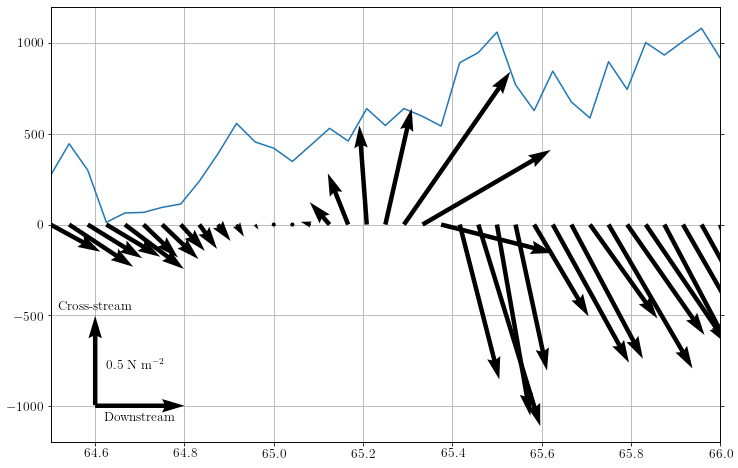

In [188]:


fig, ax = plt.subplots(1,1, sharex=True, figsize=(12,8))
ax.plot(yearday, qnet)
ax.set_ylim(-1200,1200)
ax.set_xlim(64.5, 66)
ax.grid()
ax2 = ax.twinx()
ax2.set_yticklabels([])
q = ax2.quiver(yearday, 0*yearday, tau_d, tau_cs, scale=3.75)

ax2.quiverkey(q, 64.7, -1000, 0.5, 'Downstream', coordinates='data', labelpos='S')
ax2.quiverkey(q, 64.6, -750, 0.5, 'Cross-stream', coordinates='data', angle=90, labelsep=0.65)
ax2.text(64.625, -800, '0.5 N m$^{-2}$')
ax2.set_ylim(-1200, 1200)


In [90]:
np.array([np.array(yearday), 0*np.array(yearday)]).shape

(2, 80)

In [127]:
np.max(tmag)

1.181446135909563